<a href="https://colab.research.google.com/github/seoh9510/DKU_RBLNs_Collabo_2024/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 합성곱 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org에서 보기</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/cnn.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     구글 코랩(Colab)에서 실행하기</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/cnn.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     깃허브(GitHub) 소스 보기</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a>   </td>
</table>

*이* 튜토리얼은 CIFAR-10 숫자를 분류하기 위해 간단한 [합성곱 신경망](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network)(Convolutional Neural Network, CNN)을 훈련합니다. 이 튜토리얼은 [케라스 Sequential API](https://www.cs.toronto.edu/~kriz/cifar.html)를 사용하기 때문에 몇 줄의 코드만으로 모델을 만들고 훈련할 수 있습니다.


### 텐서플로 임포트하기 + (Added) 사전 함수 정의하기

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import cv2
%matplotlib inline

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()


### CIFAR-10 데이터셋 다운로드하고 준비하기

CIFAR10 데이터세트에는 10개 클래스에 60,000개의 컬러 이미지가 포함되어 있으며 각 클래스에는 6,000개의 이미지가 있습니다. 이 데이터세트는 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 나뉩니다. 클래스는 상호 배타적이며 서로 겹치지 않습니다.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 6s 0us/step


### 데이터 확인하기

데이터세트가 올바른지 확인하기 위해 훈련 세트의 처음 25개 이미지를 플로팅하고 각 이미지 아래에 클래스 이름을 표시해 보겠습니다.


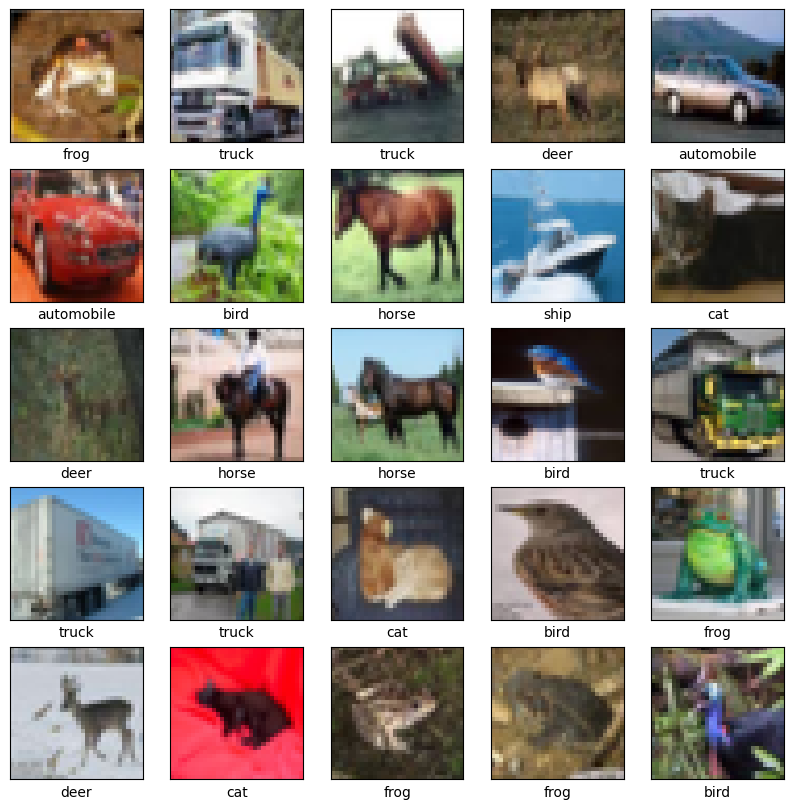

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


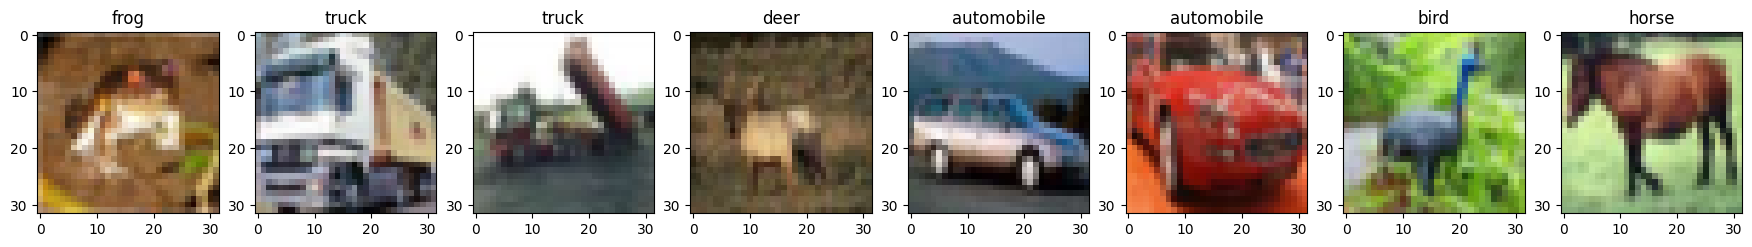

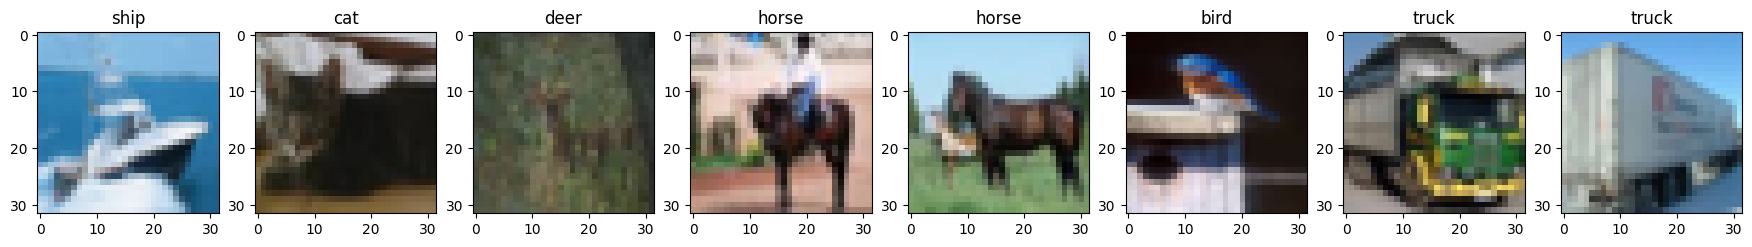

In [ ]:
# @title Custom Image Show
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
print(train_labels[:10])

show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

### 합성곱 층 만들기

아래 6줄의 코드에서 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.

입력으로 CNN은 배치 크기를 무시하고 형상(image_height, image_width, color_channels)의 텐서를 사용합니다. 이러한 차원을 처음 접하는 경우 color_channels는 (R,G,B)를 나타냅니다. 이 예에서는 CIFAR 이미지 형식인 형상(32, 32, 3)의 입력을 처리하도록 CNN을 구성합니다. `input_shape` 인수를 첫 번째 레이어에 전달하여 이를 수행할 수 있습니다.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

지금까지 모델의 아키텍처를 표시해 보겠습니다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 56320 

위에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가집니다. Conv2D 층에서 출력 채널의 수는 첫 번째 매개변수에 의해 결정됩니다(예를 들면, 32 또는 64). 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있습니다.

### 마지막에 Dense 층 추가하기

모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행합니다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서입니다. 먼저 3D 출력을 1D로 펼치겠습니다. 그다음 하나 이상의 Dense 층을 그 위에 추가하겠습니다. MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용합니다.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

다음은 모델의 전체 아키텍처입니다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

네트워크 요약은 (4, 4, 64) 출력이 두 개의 Dense 레이어를 거치기 전에 (1024) 형상의 벡터로 평면화되었음을 보여줍니다.

### 모델 컴파일과 훈련하기

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 14s 6ms/step - loss: 1.5227 - accuracy: 0.4398 - val_loss: 1.2690 - val_accuracy: 0.5400
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1442 - accuracy: 0.5945 - val_loss: 1.1150 - val_accuracy: 0.6036
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9917 - accuracy: 0.6512 - val_loss: 1.0420 - val_accuracy: 0.6389
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8958 - accuracy: 0.6849 - val_loss: 0.9183 - val_accuracy: 0.6809
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8313 - accuracy: 0.7083 - val_loss: 0.8878 - val_accuracy: 0.6974
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7759 - accuracy: 0.7270 - val_loss: 0.9098 - val_accuracy: 0.6855
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7312 - accuracy: 0.7434 - val_loss: 0.8864 - val_accura

### 모델 평가

313/313 - 1s - loss: 0.8656 - accuracy: 0.7124 - 660ms/epoch - 2ms/step


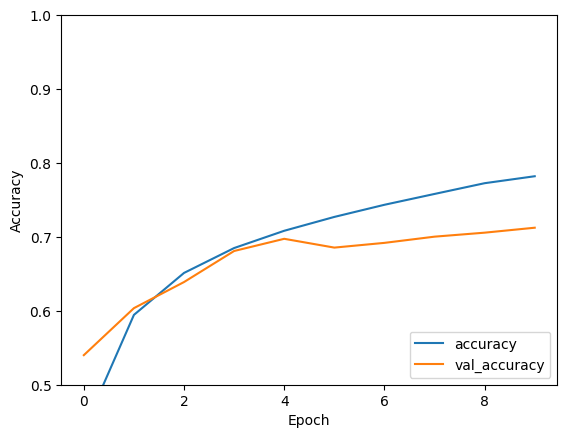

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

0.7124000191688538


313/313 [==============================] - 1s 3ms/step - loss: 0.8656 - accuracy: 0.7124


[0.8656071424484253, 0.7124000191688538]

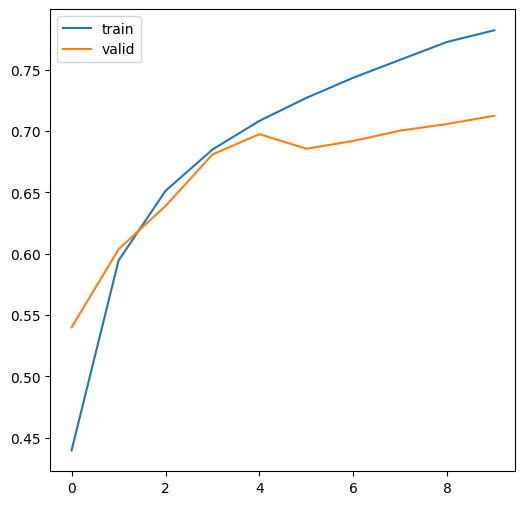

In [ ]:
# @title Custom Evaluation

show_history(history)

# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_labels)

In [ ]:
# 테스트용 4차원 이미지 배열을 입력해서 predict()수행.
preds = model.predict(np.expand_dims(test_images[0], axis=0))
# preds = model.predict(test_images[:32], batch_size=32) # 32개 예측
print('예측 결과 shape:', preds.shape)
print('예측 결과:', preds)

predicted_class = np.argmax(preds, axis=1)
print('예측 클래스 값:', predicted_class)

show_images(test_images[:8], predicted_class[:8], ncols=8)
show_images(test_images[:8], test_labels[:8], ncols=8)